# LL Surfaces

---

Aditya Marathe

**Aims**:

- Understand how PyOscCalc works...
    - *My understanding*: It simulates matter effects on oscillation prob.
- Calculate LL for our data...

Useful equations for an oscillation fit:

$$
    \text{ln}\mathscr{L} = - \sum_{i=1}^N \left( \text{P}_i(\text{Osc. Params.}) - \text{O}_i + \text{O}_i \times \text{ln} \frac{\text{O}_i}{\text{P}_i(\text{Osc. Params.})} \right)
$$

$$
    \chi^2 = - 2 \text{ln} \mathscr{L}
$$

where $\text{P}_i(\text{Osc. Params.})$ is the predicted energy distribution calculated by passing the possible oscillation parameters to an oscillation calculator (PyOscCalc) and $\text{O}_i$ is the observed energy distribution from the experiment.

What are the oscillation parameters are we fitting for?

- $\text{sin}^2 \theta_{23}$
- $\Delta m_{31}^2$
- $\delta_\text{CP}$

Stuff we cannot fit, so we just constrain them...

- $\text{sin}^2 \theta_{12} = 0.307$
- $\text{sin}^2 \theta_{13} = 0.0210 \pm 0.0011$
- $\Delta m_{21}^2 = 7.53 \times 10^{-5} \;\; \text{eV}^2$


In [2]:
%matplotlib inline

import numpy as np

import matplotlib as mlp
from matplotlib import pyplot as plt

In [3]:
import sys

sys.path.insert(1, './../../pyosccalc/')
sys.path.insert(1, './../')

In [4]:
import ana
from utils import *
from cuts import *

In [5]:
from OscCalc import OscCalc
from FluxTools import FluxTools, LogNormalFlux
from FitTools import FitTools

In [6]:
osccalc = OscCalc()

In [7]:
# Calculating the oscillation probabilities...
# A small delta was added to the bin values to prevent a ZeroDivisionError

bins = np.linspace(0.1, 5, 10_000)

mu_survival = np.asarray(
    [osccalc.MuToMu(energy) for energy in bins]
)
e_appearance = np.asarray(
    [osccalc.MuToElec(energy) for energy in bins]
)
tau_appearance = np.asarray(
    [osccalc.MuToTau(energy) for energy in bins]
)

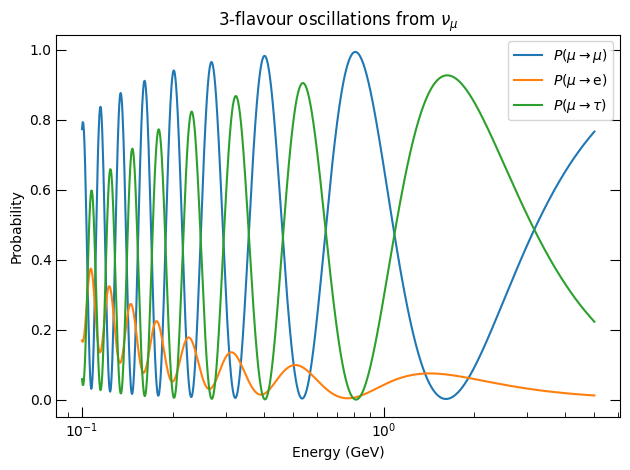

In [8]:
fig, ax = custom_subplots()

ax.plot(bins, mu_survival, label=r'$P(\mu\rightarrow\mu)$')
ax.plot(bins, e_appearance, label=r'$P(\mu\rightarrow\text{e})$')
ax.plot(bins, tau_appearance, label=r'$P(\mu\rightarrow\tau)$')

ax.legend()

ax.set_xscale('log')

ax.set_title(r'3-flavour oscillations from $\nu_\mu$')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Probability')

plt.tight_layout();

In [9]:
fluxtools = FluxTools()
lognormflux = LogNormalFlux()

pdf = fluxtools.pdfwrap(lognormflux)

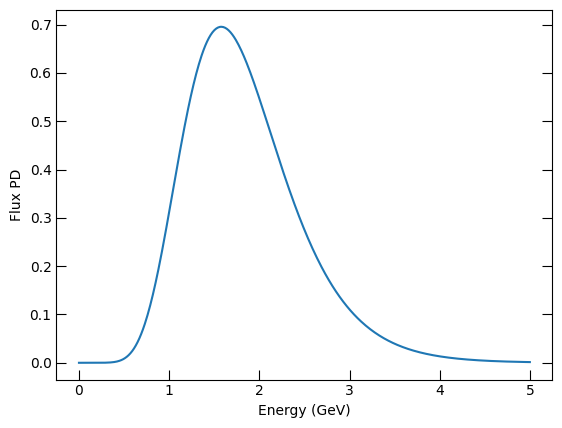

In [10]:
fig, ax = custom_subplots()

bins = np.linspace(0, 5, pdf.shape[0])

ax.plot(bins, pdf)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux PD');

In [11]:
# Create an experiment
bin_weights = fluxtools.getNuMuAsimov(flux=lognormflux, osccalc=osccalc)
bin_edges = fluxtools.binEdges

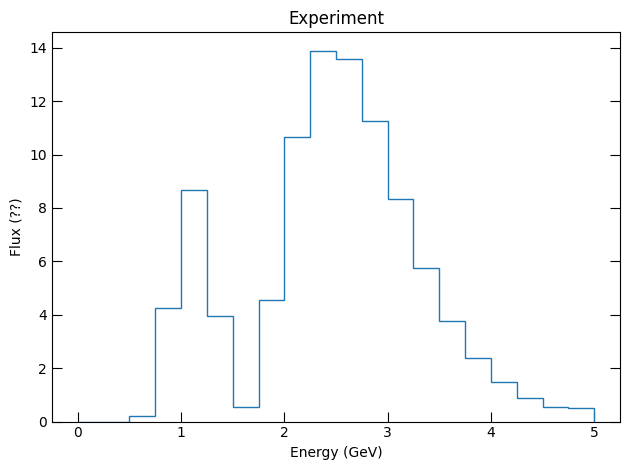

In [12]:
fig, ax = custom_subplots()

ax.hist(bin_edges[:-1], bin_edges, weights=bin_weights, histtype='step')

ax.set_title('Experiment')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [13]:
# Experiments in a bunch of fake universes...
exp_universes = [
    fluxtools.genNuMuExperiment(lognormflux, osccalc) for _ in range(10_000)
]

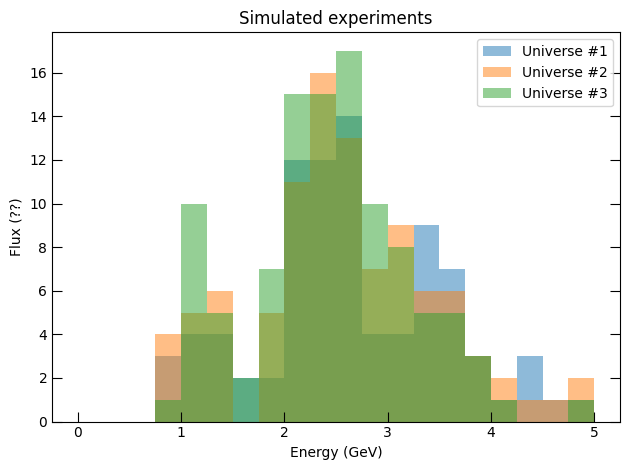

In [14]:
fig, ax = custom_subplots()

for i, exp_universe in enumerate(exp_universes[:3]):
    ax.hist(
        bin_edges[:-1], 
        bin_edges, 
        weights=exp_universe, 
        alpha=0.5,
        label=f'Universe #{i + 1}'
    )

ax.legend()

ax.set_title('Simulated experiments')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [15]:
# Calculating Least Likelihood...

# Possible osc. parameters in the multi-verse...
d_m32_array = np.linspace(2.2E-3, 2.6E-3, 20)
sin_sq_23_array = np.linspace(0.35, 0.65, 20)
d_cp_array = np.linspace(0, 2 * np.pi, 20)

asimov_array = fluxtools.makeNuMuAsimovArray(
    lognormflux, 
    osccalc,
    d_m32_array,
    sin_sq_23_array,
    d_cp_array
)

mu_ll_array_test = [
    [
        [
            FitTools.getPoissonLL(asimov, bin_weights) for asimov in asimov_row
        ] for asimov_row in asimov_mat
    ] for asimov_mat in asimov_array
]

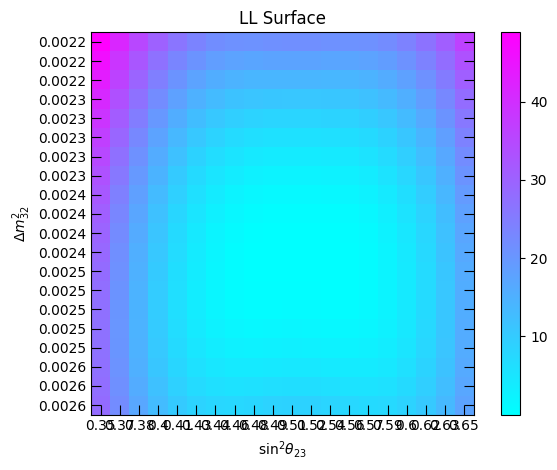

In [16]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array_test, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

## LL (Current cuts)

In [17]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [18]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [19]:
from utils import *

In [20]:
df = load_nova_sample(ds.REALLY_MINI_DIR, n_events=10_000_000)

C:\Users\Shrey\AppData\Local\Temp\ipykernel_22120\111577333.py:1: DeprecationWarning: Function `load_nova_sample` has been deprecated, use the `NOvAData` class from 'data.py' instead!
  df = load_nova_sample(ds.REALLY_MINI_DIR, n_events=10_000_000)


In [21]:
from transforms import *

In [22]:
cuts = ana.Cuts.init_nova_cuts()

In [23]:
full_cut_table = cuts.apply_all_cuts(data.table)

In [63]:
# truth_data = df[df['isNuMuCC'] > 0]['trueEnu']
truth_data = data.table[data.table['rec.mc.nu.E'] > 0]['rec.mc.nu.E']
# experiment_data = df[df['numufull'] > 0]['rec.energy.numu.lstmnu']
experiment_data = full_cut_table['rec.energy.numu.lstmnu']

In [64]:
def oscillated_spectrum(energy):
    return (
        1 - np.sin(1.27 * 2.35E-3 * 810 / energy)**2
    )


def lerp(x, x1, x2, y1, y2):
    m = (y2 - y1) / (x2 - x1)
    return y1 + m * (x - x1)


def probcalc_gen(sorted_espec, sorted_ospec):    
    def probcalc(x):
        return np.interp(
            x=x,
            xp=sorted_espec,
            fp=sorted_ospec,
            left=0,
            right=0
        )
    
    return probcalc


def ll_surface(energy):
    # oscilated spectrum
    osc_spectrum_weights = oscillated_spectrum(energy)

    sorted_espec = energy.sort_values()
    sorted_ospec = osc_spectrum_weights[sorted_espec.index].values

    # experiment flux
    probcalc = probcalc_gen(sorted_espec, sorted_ospec)
    flux = fluxtools.getAsimov(lognormflux, probcalc)

    # ll
    mu_ll_array = [
        [
            [
                FitTools.getPoissonLL(asimov, flux) for asimov in asimov_row
            ] for asimov_row in asimov_mat
        ] for asimov_mat in asimov_array
    ]

    return mu_ll_array


In [65]:
mu_ll_array_exp = ll_surface(experiment_data)

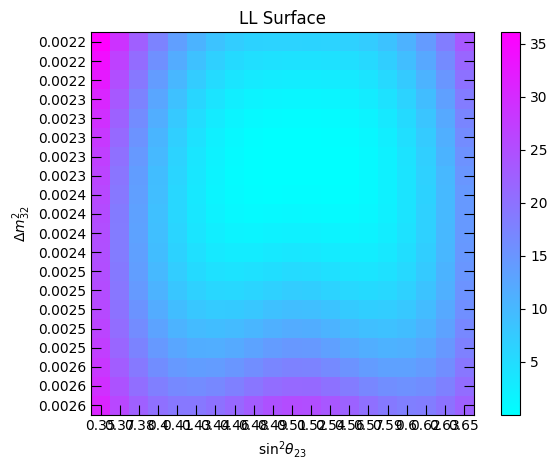

In [66]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array_exp, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

In [67]:
dcpLLArray_exp = FitTools.profile3Dto1D(mu_ll_array_exp, 0)
sinLLArray_exp=FitTools.profile3Dto1D(mu_ll_array_exp,1)
dmLLArray_exp = FitTools.profile3Dto1D(mu_ll_array_exp, 2);

(0, 1, 2)
(1, 2, 0)
(2, 0, 1)


In [68]:
# =================================================================

In [69]:
mu_ll_array = ll_surface(truth_data)

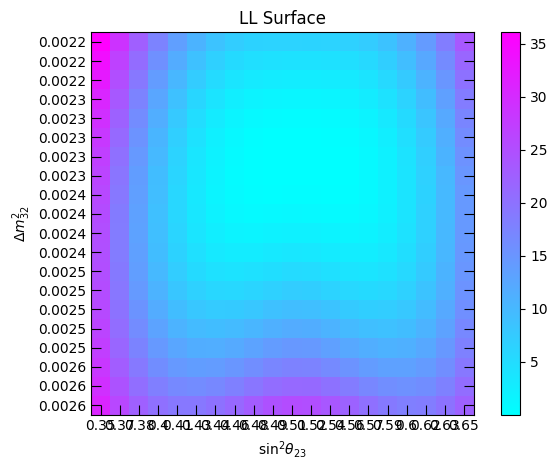

In [70]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

In [71]:
dcpLLArray = FitTools.profile3Dto1D(mu_ll_array, 0)
sinLLArray=FitTools.profile3Dto1D(mu_ll_array,1)
dmLLArray = FitTools.profile3Dto1D(mu_ll_array, 2);

(0, 1, 2)
(1, 2, 0)
(2, 0, 1)


In [72]:
# ===================================================================

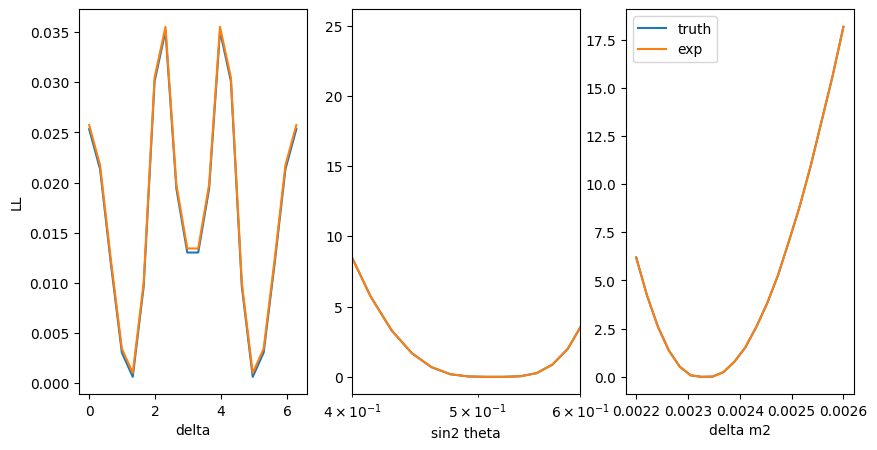

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(d_cp_array, dcpLLArray, label='truth')
axs[0].plot(d_cp_array, dcpLLArray_exp, label='exp')
axs[0].set_ylabel('LL')
axs[0].set_xlabel('delta')

axs[1].plot(sin_sq_23_array, sinLLArray, label='truth')
axs[1].plot(sin_sq_23_array, sinLLArray_exp, label='exp')
axs[1].set_xlabel('sin2 theta')
axs[1].set_xlim(0.4, 0.6)
axs[1].set_xscale('log')

axs[2].plot(d_m32_array, dmLLArray, label='truth')
axs[2].plot(d_m32_array, dmLLArray_exp, label='exp')
axs[2].set_xlabel('delta m2')

axs[2].legend();